This is needed to reload modules without restarting the kernel

In [1]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [2]:
import os
os.sys.path.append('../../')

# Trying to use a LightGBM for reweighting

In [3]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
f = uproot.open('/mnt/storage/lborgna/NNT/data17_with_weights.root')

In [6]:
df_cr = f['control'].pandas.df()

In [8]:
from eda_tools.NN_RW import nominal, louppe_loss, log_inputs, create_labels, NN

Using TensorFlow backend.


In [9]:
features_to_rw = nominal()

In [10]:
features_to_rw

{'rw_cols_to_log': ['pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'X_wt'],
 'rw_cols_log': ['pT_2_log',
  'pT_4_log',
  'eta_i',
  'dRjj_1_log',
  'dRjj_2_log',
  'njets',
  'pt_hh_log',
  'X_wt_log',
  'dR_hh',
  'dPhi_h1',
  'dPhi_h2']}

In [11]:
from eda_tools.utilities import calculatedPhi, calculatedRhh

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
calculatedPhi(df_cr)
calculatedRhh(df_cr)

In [13]:
log_inputs(df_cr, to_log=features_to_rw['rw_cols_to_log'])

In [14]:
rw_columns =features_to_rw['rw_cols_log']

In [15]:
train_size = df_cr.shape[0]

In [16]:
original = df_cr.loc[df_cr['ntag'] == 2, features_to_rw['rw_cols_log']]

In [17]:
target = df_cr.loc[df_cr['ntag']>=4, features_to_rw['rw_cols_log']]

In [18]:
X_all = pd.concat((original, target), ignore_index=True).values
Y_all = create_labels(original, target)

In [19]:
Y_all = Y_all.astype('float32')

In [20]:
scaler = StandardScaler()

In [21]:
X_train = scaler.fit_transform(X_all)
Y_train = Y_all.copy()

In [22]:
idx = np.random.permutation(X_train.shape[0])

In [23]:
idx.shape

(1768324,)

In [24]:
X_train = X_train[idx]
Y_train = Y_train[idx]

In [ ]:
d_train = l

In [40]:
pred = model.predict_proba(scaler.transform(df_cr.loc[df_cr.ntag==2, rw_columns].values))

In [41]:
df_cr.loc[df_cr.ntag==2, 'weight'] = pred[:,0]/ pred[:,1]

In [42]:
df_cr.fillna({"weight":1}, inplace =True)

In [43]:
mask2b = df_cr['ntag'] ==2
mask4b = df_cr['ntag'] >=4
maskCR = df_cr['kinematic_region']==2

In [44]:
norm = df_cr[mask4b].shape[0] / df_cr.loc[mask2b, 'weight'].sum()

In [45]:
norm

1.0260452341000004

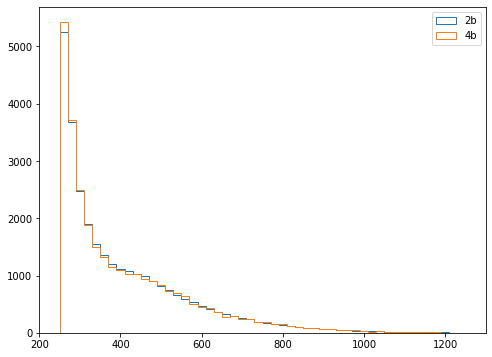

In [46]:
f, ax = plt.subplots(figsize=(8,6))
h2b, be, _ = plt.hist(
    df_cr.loc[mask2b, "m_hh_cor"].values,
    bins=50,
    histtype="step",
    range=(250, 1250),
    weights=norm*df_cr.loc[mask2b, "weight"].values,
    label="2b",
)
h4b, _, _ = plt.hist(
    df_cr.loc[mask4b, "m_hh_cor"].values, bins=be, histtype="step", label="4b"
)
plt.legend()

(-10.0, 10.0)

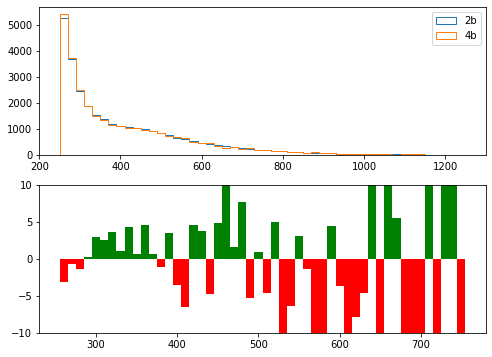

In [47]:
f, ax = plt.subplots(2, 1, figsize=(8,6))
h2b, be, _ = ax[0].hist(
    df_cr.loc[mask2b, "m_hh_cor"].values,
    bins=50,
    histtype="step",
    range=(250, 1250),
    weights=norm*df_cr.loc[mask2b, "weight"].values,
    label="2b",
)
h4b, _, _ = ax[0].hist(
    df_cr.loc[mask4b, "m_hh_cor"].values, bins=be, histtype="step", label="4b"
)
ax[0].legend()
percentages = 100 * (h2b-h4b)/h4b
x = 0.5*(be[:1]+be[1:])
width = x[1] - x[0]
#ax[1].bar(x, percentages, width=width)
ax[1].bar(x[percentages<0], percentages[percentages<0], color='red', width=width)
ax[1].bar(x[percentages>0], percentages[percentages>0], color='green', width=width)
ax[1].set_ylim(-10, 10)

# Feature Importance

In [48]:
from xgboost import plot_importance

In [49]:
help(plot_importance)

Help on function plot_importance in module xgboost.plotting:

plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', fmap='', importance_type='weight', max_num_features=None, grid=True, show_values=True, **kwargs)
    Plot importance based on fitted trees.
    
    Parameters
    ----------
    booster : Booster, XGBModel or dict
        Booster or XGBModel instance, or dict taken by Booster.get_fscore()
    ax : matplotlib Axes, default None
        Target axes instance. If None, new figure and axes will be created.
    grid : bool, Turn the axes grids on or off.  Default is True (On).
    importance_type : str, default "weight"
        How the importance is calculated: either "weight", "gain", or "cover"
    
        * "weight" is the number of times a feature appears in a tree
        * "gain" is the average gain of splits which use the feature
        * "cover" is the average coverage of splits which use 

In [50]:
plot_importance(model, ylabel='test', fmap= features_to_rw['rw_cols_log'])

TypeError: expected str, bytes or os.PathLike object, not list

In [51]:
df_test = pd.DataFrame({'feature importance': model.feature_importances_, 'feature name': features_to_rw['rw_cols_log']})

In [52]:
df_test.sort_values(by='feature importance', ascending=False, inplace = True)

In [53]:
df_test

feature importance feature name
5             0.520729        njets
8             0.143348        dR_hh
6             0.089076    pt_hh_log
1             0.066579     pT_4_log
0             0.038217     pT_2_log
4             0.029163   dRjj_2_log
7             0.025887     X_wt_log
9             0.022836      dPhi_h1
3             0.022150   dRjj_1_log
10            0.021480      dPhi_h2
2             0.020536        eta_i

<BarContainer object of 11 artists>

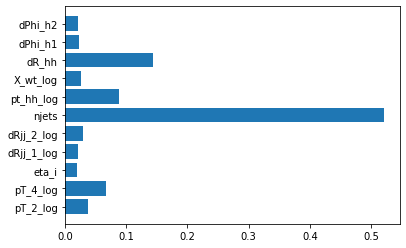

In [54]:
plt.barh(features_to_rw['rw_cols_log'], model.feature_importances_)


In [55]:
import seaborn as sns

Text(0.5, 1.0, 'XGBoost Model X Feature Importance')

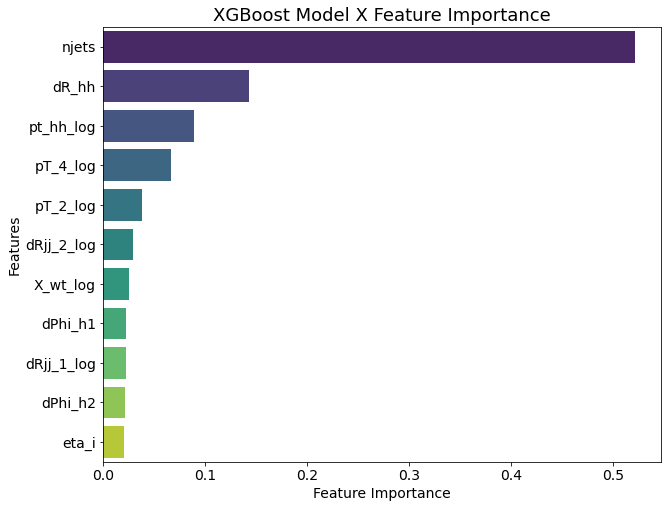

In [56]:
f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x="feature importance", y="feature name", data=df_test,
                 palette="viridis",ax=ax)
ax.set_ylabel('Features', fontsize = 14)
ax.set_xlabel('Feature Importance', fontsize = 14)
ax.tick_params(axis='both',which='major',labelsize=14)
ax.set_title("XGBoost Model X Feature Importance", fontsize = 18)

# SHAP EXPLAINABILITY

In [226]:
X_train

array([[ 1.33520483, -0.91592952, -0.50574989, ...,  0.39213915,
        -1.60457223, -1.10669329],
       [ 1.39335967,  0.26500773, -0.59074104, ...,  0.54458543,
        -1.20578848, -1.28547205],
       [ 0.33548848, -0.85812125, -0.46083904, ...,  0.7082063 ,
         1.01351312,  0.07288921],
       ...,
       [ 0.36317595, -1.24274726,  0.84869292, ...,  0.12377528,
        -1.15409998,  0.76723113],
       [ 1.78489182, -0.17677873, -1.00965608, ...,  0.91368331,
        -0.54174375, -0.32445997],
       [ 0.29691962,  0.42485154, -0.19850847, ...,  0.0769238 ,
        -1.29479317, -1.35888231]])

In [227]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [58]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[0,:])

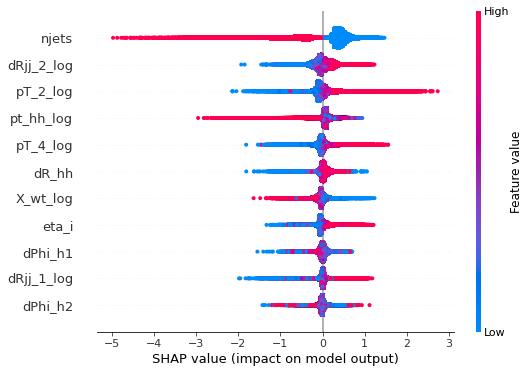

In [64]:
shap.summary_plot(shap_values, X_train, feature_names=features_to_rw["rw_cols_log"])

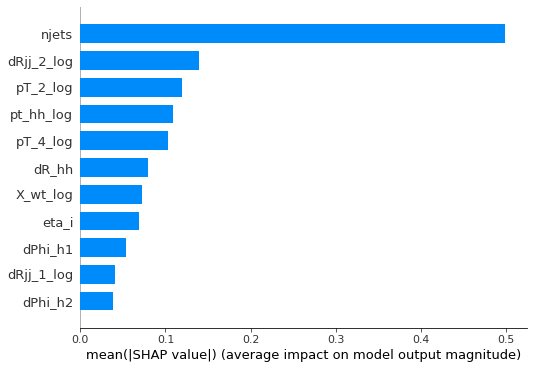

In [65]:
shap.summary_plot(
    shap_values, X_train, feature_names=features_to_rw["rw_cols_log"], plot_type="bar"
)

# XGBOOST plot tree

In [66]:
import sklearn

In [67]:
sklearn.__version__

'0.22'

In [68]:
from xgboost import plot_tree

In [69]:
model.plot_tree(model)

AttributeError: 'XGBClassifier' object has no attribute 'plot_tree'

In [128]:
help(plot_tree)

Help on function plot_tree in module xgboost.plotting:

plot_tree(booster, fmap='', num_trees=0, rankdir=None, ax=None, **kwargs)
    Plot specified tree.
    
    Parameters
    ----------
    booster : Booster, XGBModel
        Booster or XGBModel instance
    fmap: str (optional)
       The name of feature map file
    num_trees : int, default 0
        Specify the ordinal number of target tree
    rankdir : str, default "TB"
        Passed to graphiz via graph_attr
    ax : matplotlib Axes, default None
        Target axes instance. If None, new figure and axes will be created.
    kwargs :
        Other keywords passed to to_graphviz
    
    Returns
    -------
    ax : matplotlib Axes



In [123]:
import xgboost

In [124]:
xgboost.__version__

'1.3.3'

# Hyper-parameter tunning with XGBOOST

In [70]:
from sklearn.metrics import accuracy_score

In [71]:
from sklearn.preprocessing import LabelEncoder

In [72]:
le = LabelEncoder()

In [73]:
Y_train_encoded = le.fit_transform(Y_train)

In [74]:
Y_train_encoded

array([1, 1, 1, ..., 1, 1, 1])

In [75]:
Y_train

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
x_tra, x_eval, y_tra, y_eval = train_test_split(X_train, Y_train_encoded, test_size=0.2)

In [91]:
from xgboost.callback import EarlyStopping, TrainingCheckPoint

In [110]:
import xgboost as xgb

In [114]:
import os

In [117]:
os.getcwd()

'/home/lborgna/hh4b-studies/hh4b-reweighting-studies/Notebooks'

In [219]:
params = {
    'max_depth': 5,
    'learning_rate': 0.3,
    'n_estimators': 500,
    'gamma': 0,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'scale_pos_weight': 1,
    'min_child_weight': 1,
    'reg_alpha':0.1,
    'objective':'binary:logistic',
    'use_label_encoder':True
}

In [220]:
model = XGBClassifier(**params)

In [221]:
from tensorflow.keras.utils import to_categorical

In [222]:
y_tra_enc = to_categorical(y_tra, num_classes=2)
y_eval_enc = to_categorical(y_eval, num_classes=2)

In [223]:

pw_train = np.random.poisson(1, x_tra.shape[0])
pw_test = np.random.poisson(1, x_eval.shape[0])

In [224]:
model.fit(
    x_tra,
    y_tra,
    sample_weight=pw_train,
    eval_set=[(x_eval, y_eval)],
    eval_metric="logloss",
    verbose=True,
    early_stopping_rounds=20,
)

[0]	validation_0-logloss:0.45372
[1]	validation_0-logloss:0.32256
[2]	validation_0-logloss:0.24125
[3]	validation_0-logloss:0.18810
[4]	validation_0-logloss:0.15184
[5]	validation_0-logloss:0.12747
[6]	validation_0-logloss:0.11104
[7]	validation_0-logloss:0.09996
[8]	validation_0-logloss:0.09205
[9]	validation_0-logloss:0.08691
[10]	validation_0-logloss:0.08351
[11]	validation_0-logloss:0.08027
[12]	validation_0-logloss:0.07898
[13]	validation_0-logloss:0.07751
[14]	validation_0-logloss:0.07704
[15]	validation_0-logloss:0.07678
[16]	validation_0-logloss:0.07623
[17]	validation_0-logloss:0.07612
[18]	validation_0-logloss:0.07604
[19]	validation_0-logloss:0.07600
[20]	validation_0-logloss:0.07598
[21]	validation_0-logloss:0.07571
[22]	validation_0-logloss:0.07553
[23]	validation_0-logloss:0.07555
[24]	validation_0-logloss:0.07555
[25]	validation_0-logloss:0.07551
[26]	validation_0-logloss:0.07536
[27]	validation_0-logloss:0.07537
[28]	validation_0-logloss:0.07539
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=36, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.1,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [225]:
model.best_ntree_limit

34

In [206]:
model.save_model('test.json')

In [207]:
model.dump_model('test_dump.json')

AttributeError: 'XGBClassifier' object has no attribute 'dump_model'

In [205]:
!ls -lhtr

total 19M
-rw-r--r-- 1 lborgna users    0 May  2  2020 test.ipynb
-rw-r--r-- 1 lborgna users 119K May 10  2020 2btcomb.PNG
-rw-r--r-- 1 lborgna users 139K May 10  2020 2bscomb.PNG
-rw-r--r-- 1 lborgna users 178K May 10  2020 2bsvs2bt.PNG
-rw-r--r-- 1 lborgna users 104K May 13  2020 ImplementingBoostraps.ipynb
-rw-r--r-- 1 lborgna users 326K May 15  2020 MixturePDF.ipynb
-rw-r--r-- 1 lborgna users  44K May 18  2020 SplitTogetherPart2.ipynb
-rw-r--r-- 1 lborgna users 3.6M May 27  2020 SplitTogether.ipynb
-rw-r--r-- 1 lborgna users 1.6K Jan 18 15:12 notebook template.ipynb
-rw-r--r-- 1 lborgna users 581K Feb 13 13:38 regions_definitions.png
-rw-r--r-- 1 lborgna users  44K Feb 14 18:52 BatchSize.ipynb
-rw-r--r-- 1 lborgna users 793K Feb 23 16:58 Angular massplane.ipynb
-rw-r--r-- 1 lborgna users 145K Feb 24 11:50 RandomForestClassifier.ipynb
-rw-r--r-- 1 lborgna users 150K Feb 24 11:51 Support Vector Reweighting.ipynb
-rw-r--r-- 1 lborgna users  45K Mar 18 22:56 VAE.ipynb
drwxr-xr-x 2 lbor

# ATTEMPTING AT A MODEL CHECKPOINT (FAILED)

In [174]:
# fit model no training data

D_train = xgb.DMatrix(x_tra, label=y_tra)
D_valid = xgb.DMatrix(x_eval, label=y_eval)

early_stop = EarlyStopping(
    rounds=10, metric_name="logloss", save_best=True
)
checkpoint = TrainingCheckPoint(directory=os.getcwd(),name="test.json", iterations=1)


model = XGBClassifier(use_label_encoder=False)
model.fit(
    x_tra, y_tra,
    eval_set=[(x_eval, y_eval)],
    eval_metric="logloss",
    early_stopping_rounds=10,
    verbose=True,
    #callbacks=[early_stop, checkpoint],
)

# model.fit(
#     x_tra,
#     y_tra,
#     eval_set=[(x_eval, y_eval)],
#     eval_metric="logloss",
#     verbose=True,
#     callbacks = [EarlyStopping(rounds=5, metric_name = 'logloss', save_best=True)]

# )

# model.train(
#     {"objective": "binary:logistic", "eval_metric": ["logloss"]},
#     D_train,
#     evals=[(D_valid, "Valid")],
#     callbacks=[early_stop],
#     verbose_eval=True
# )

[0]	validation_0-logloss:0.45350
[1]	validation_0-logloss:0.32195
[2]	validation_0-logloss:0.24020
[3]	validation_0-logloss:0.18658
[4]	validation_0-logloss:0.15045
[5]	validation_0-logloss:0.12577
[6]	validation_0-logloss:0.10884
[7]	validation_0-logloss:0.09724
[8]	validation_0-logloss:0.08937
[9]	validation_0-logloss:0.08407
[10]	validation_0-logloss:0.08057
[11]	validation_0-logloss:0.07828
[12]	validation_0-logloss:0.07682
[13]	validation_0-logloss:0.07593
[14]	validation_0-logloss:0.07537
[15]	validation_0-logloss:0.07501
[16]	validation_0-logloss:0.07483
[17]	validation_0-logloss:0.07469
[18]	validation_0-logloss:0.07463
[19]	validation_0-logloss:0.07459
[20]	validation_0-logloss:0.07455
[21]	validation_0-logloss:0.07453
[22]	validation_0-logloss:0.07454
[23]	validation_0-logloss:0.07452
[24]	validation_0-logloss:0.07451
[25]	validation_0-logloss:0.07451
[26]	validation_0-logloss:0.07452
[27]	validation_0-logloss:0.07451
[28]	validation_0-logloss:0.07451
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=36, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [121]:
model.booster

In [128]:
model.best_iteration

30

In [132]:
model.best_ntree_limit

31

In [175]:
model.predict_proba(x_eval)

array([[0.00953996, 0.99046004],
       [0.04558969, 0.9544103 ],
       [0.01527005, 0.98472995],
       ...,
       [0.01032919, 0.9896708 ],
       [0.04057473, 0.9594253 ],
       [0.0139643 , 0.9860357 ]], dtype=float32)

In [176]:
model.predict_proba(x_eval, ntree_limit=model.best_iteration)

array([[0.0095365 , 0.9904635 ],
       [0.04543525, 0.95456475],
       [0.01493227, 0.9850677 ],
       ...,
       [0.01048446, 0.98951554],
       [0.03969973, 0.96030027],
       [0.01443833, 0.98556167]], dtype=float32)

In [177]:
w_best = model.predict_proba(X_train, ntree_limit=model.best_ntree_limit)

In [178]:
w_best

array([[0.01058543, 0.9894146 ],
       [0.00674284, 0.99325716],
       [0.00891137, 0.9910886 ],
       ...,
       [0.00739515, 0.99260485],
       [0.01646525, 0.98353475],
       [0.01032674, 0.98967326]], dtype=float32)

In [179]:
w_last = model.predict_proba(X_train)

In [180]:
w_last

array([[0.01058543, 0.9894146 ],
       [0.00674284, 0.99325716],
       [0.00891137, 0.9910886 ],
       ...,
       [0.00739515, 0.99260485],
       [0.01646525, 0.98353475],
       [0.01032674, 0.98967326]], dtype=float32)

In [158]:
pred_best = model.predict_proba(scaler.transform(df_cr.loc[df_cr.ntag==2, rw_columns].values), ntree_limit=model.best_ntree_limit)
df_cr.loc[df_cr.ntag==2, 'weight_best'] = pred[:,0]/ pred[:,1]
df_cr.fillna({"weight_best":1}, inplace =True)

In [162]:
pred_last = model.predict_proba(scaler.transform(df_cr.loc[df_cr.ntag==2, rw_columns].values), ntree_limit=34)
df_cr.loc[df_cr.ntag==2, 'weight_last'] = pred[:,0]/ pred[:,1]
df_cr.fillna({"weight_last":1}, inplace =True)

In [163]:
norm_best = df_cr[mask4b].shape[0] / df_cr.loc[mask2b, 'weight_best'].sum()
norm_last = df_cr[mask4b].shape[0] / df_cr.loc[mask2b, 'weight_last'].sum()

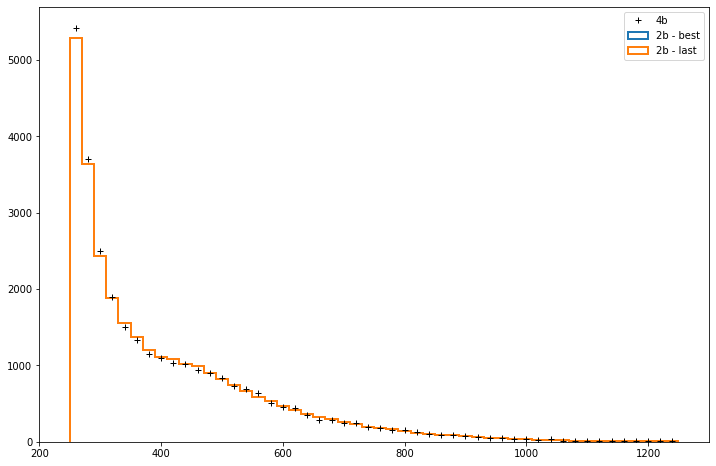

In [164]:
f, ax = plt.subplots(figsize=(12,8))
h2b, be, _ = plt.hist(
    df_cr.loc[mask2b, "m_hh_cor"].values,
    bins=50,
    histtype="step",
    range=(250, 1250),
    weights=norm_best*df_cr.loc[mask2b, "weight_best"].values,
    label="2b - best",
    lw = 2,
)
_ = plt.hist(
    df_cr.loc[mask2b, 'm_hh_cor'].values,
    bins =be,
    histtype='step',
    weights=norm_last*df_cr.loc[mask2b, 'weight_last'].values,
    label = "2b - last",
    lw= 2,
)
h4b, _ = np.histogram(
    df_cr.loc[mask4b, "m_hh_cor"].values, bins=be,
)
x = 0.5*(be[:-1]+be[1:])
plt.plot(x, h4b, 'k+', label = '4b')
plt.legend()

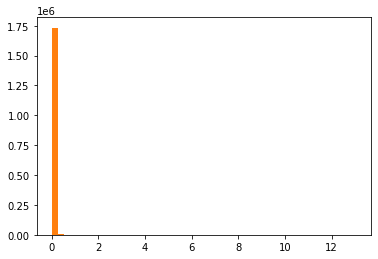

In [165]:
_, be, _ = plt.hist(df_cr.loc[df_cr['ntag']==2,'weight_best'].values, bins = 50)
_ = plt.hist(df_cr.loc[df_cr['ntag']==2,'weight_last'].values, bins = be)

In [167]:
model.best_ntree_limit

31

In [ ]:
model.

In [166]:
df_cr[['weight_best','weight_last']]

weight_best  weight_last
entry                            
0           0.028149     0.028149
1           0.013361     0.013361
2           0.016002     0.016002
3           0.013997     0.013997
4           0.007944     0.007944
...              ...          ...
1790768     0.009231     0.009231
1790769     0.009002     0.009002
1790770     0.010563     0.010563
1790771     0.045203     0.045203
1790772     0.007714     0.007714

[1790773 rows x 2 columns]

In [160]:
pred_best

array([[0.02737802, 0.972622  ],
       [0.01318526, 0.98681474],
       [0.01574957, 0.9842504 ],
       ...,
       [0.01045263, 0.9895474 ],
       [0.04324812, 0.9567519 ],
       [0.00765461, 0.9923454 ]], dtype=float32)

In [161]:
pred_last

array([[0.02737802, 0.972622  ],
       [0.01318526, 0.98681474],
       [0.01574957, 0.9842504 ],
       ...,
       [0.01045263, 0.9895474 ],
       [0.04324812, 0.9567519 ],
       [0.00765461, 0.9923454 ]], dtype=float32)

"Best"

In [107]:
accuracy_score(y_eval, model.predict(x_eval))

0.9836483678056919

"Last"

In [108]:
accuracy_score(y_eval, model.predict(x_eval))

0.9836483678056919

In [147]:
model.set_params()

RecursionError: maximum recursion depth exceeded while calling a Python object